In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')


In [2]:
# Load data
df = pd.read_csv(r"C:\Users\USER\Downloads\cryptocurrency\binance_new1.csv")
print(df.head())

        Date    Market Cap       Volume    Open   Close
0  11/6/2024  8.216008e+10  782468124.0  563.18  591.17
1  11/5/2024  8.050932e+10  876900503.0  552.00  563.18
2  11/4/2024  8.147737e+10  807471288.0  557.97  552.00
3  11/3/2024  8.288982e+10  613502646.0  568.18  557.97
4  11/2/2024  8.357229e+10  893454862.0  572.92  568.18


In [3]:
print(df)

            Date    Market Cap       Volume    Open   Close
0      11/6/2024  8.216008e+10  782468124.0  563.18  591.17
1      11/5/2024  8.050932e+10  876900503.0  552.00  563.18
2      11/4/2024  8.147737e+10  807471288.0  557.97  552.00
3      11/3/2024  8.288982e+10  613502646.0  568.18  557.97
4      11/2/2024  8.357229e+10  893454862.0  572.92  568.18
...          ...           ...          ...     ...     ...
1457  11/10/2020  4.123746e+09  367057928.0   27.98   28.15
1458   11/9/2020  4.188048e+09  350090762.0   28.27   27.98
1459   11/8/2020  4.095631e+09  379171085.0   27.69   28.27
1460   11/7/2020  4.277112e+09  351340616.0   28.93   27.69
1461   11/6/2020  4.094008e+09  319732746.0   27.66   28.93

[1462 rows x 5 columns]


In [4]:
# Resampling to daily frequency
df['Date'] = pd.to_datetime(df['Date'])
df.index = df.Date
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

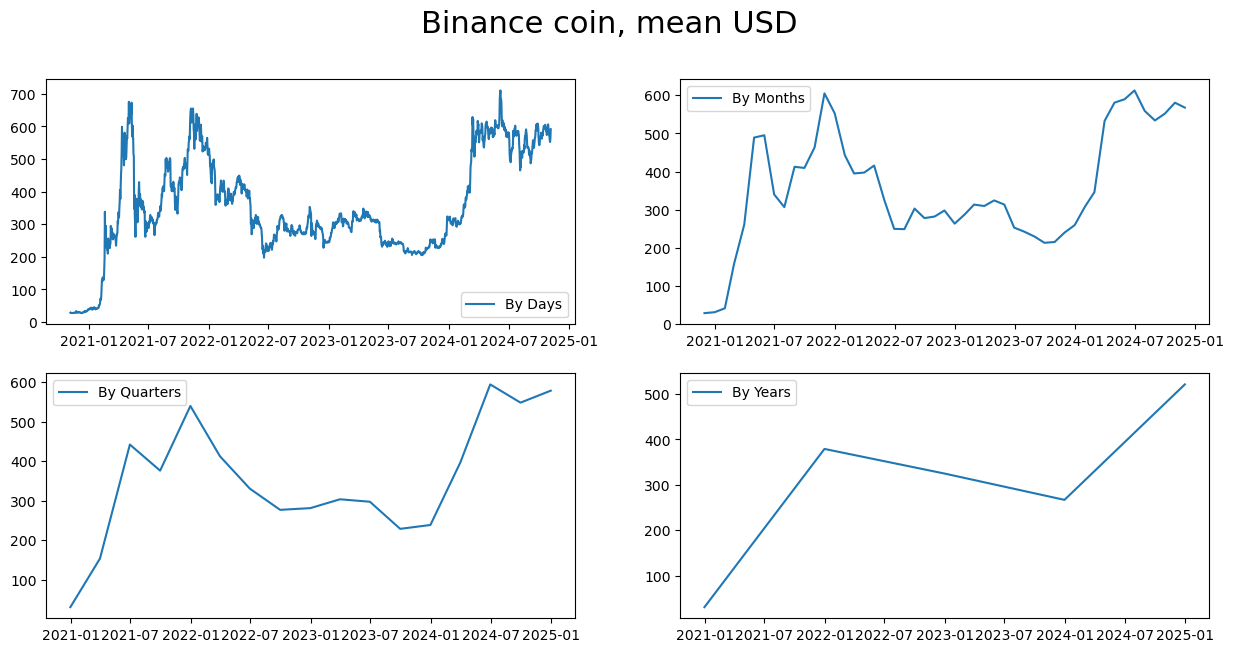

In [5]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Binance coin, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Close, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Close, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Close, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Close, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()


Dickey–Fuller test: p=0.172631


<Figure size 1500x700 with 0 Axes>

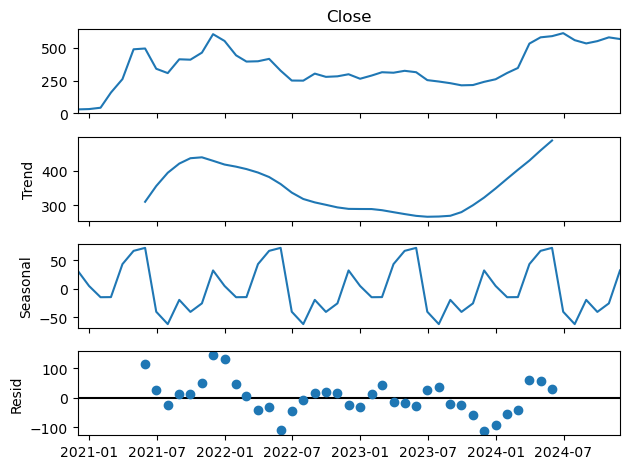

In [6]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Close).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])
plt.show()

In [7]:
# Box-Cox Transformations
df_month['Close_box'], lmbda = stats.boxcox(df_month.Close)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])

Dickey–Fuller test: p=0.172631


In [8]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Close_box - df_month.Close_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.254816


Dickey–Fuller test: p=0.010108


<Figure size 1500x700 with 0 Axes>

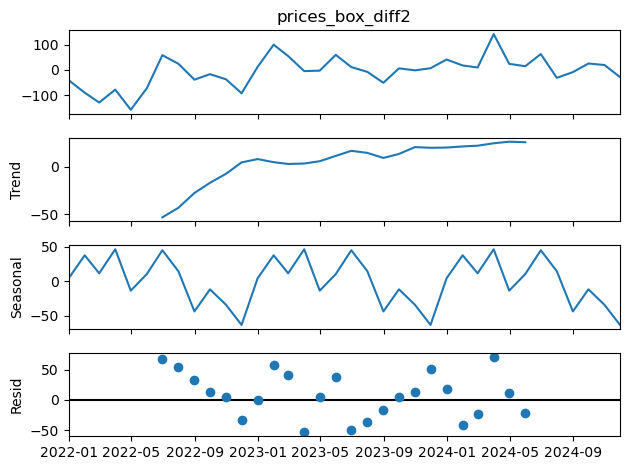

In [9]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

In [10]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Close_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [11]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
6   (0, 1, 0, 0)  389.398263
8   (0, 1, 1, 0)  391.048953
18  (1, 0, 0, 0)  391.068551
7   (0, 1, 0, 1)  391.117812
24  (1, 1, 0, 0)  391.395569
                                      SARIMAX Results                                      
Dep. Variable:                           Close_box   No. Observations:                   49
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -192.699
Date:                             Sun, 24 Nov 2024   AIC                            389.398
Time:                                     14:08:12   BIC                            392.565
Sample:                                 11-30-2020   HQIC                           390.504
                                      - 11-30-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

Dickey–Fuller test:: p=0.000001


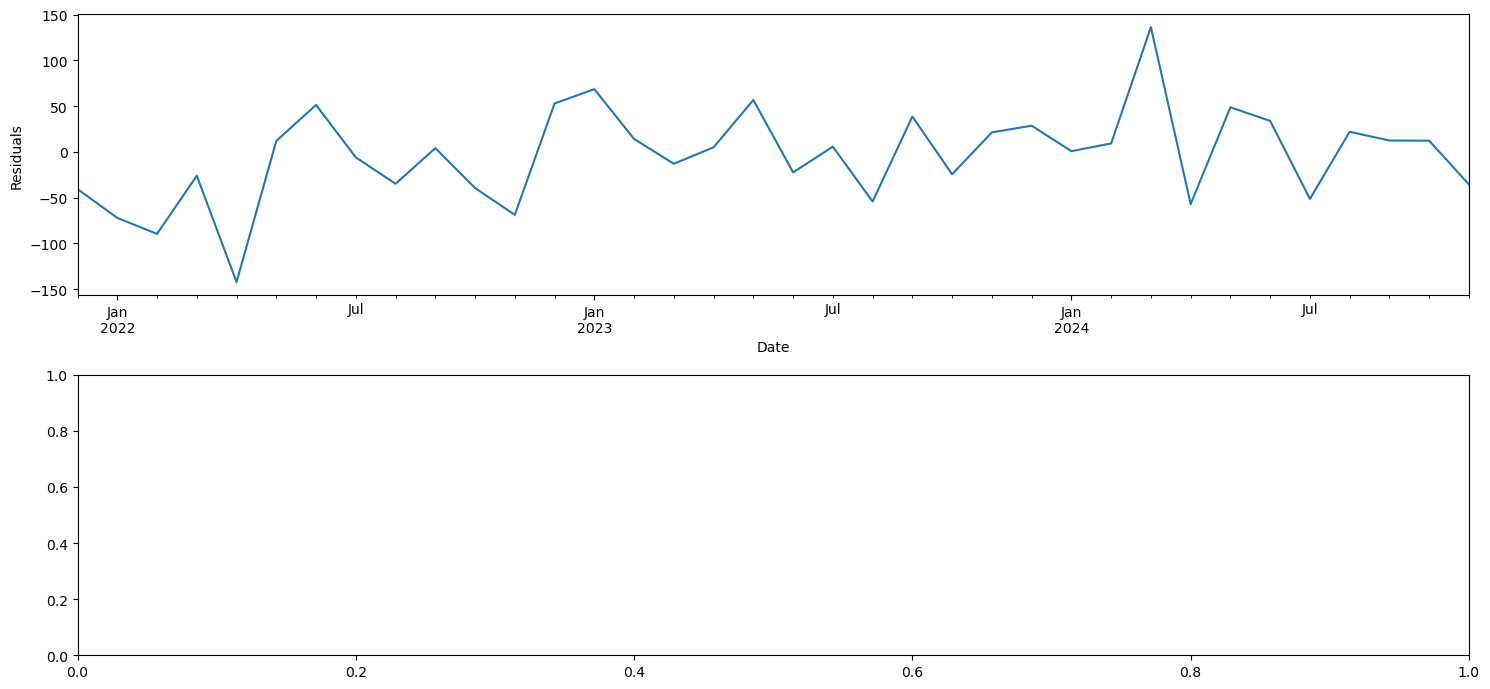

In [12]:
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)


print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [13]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

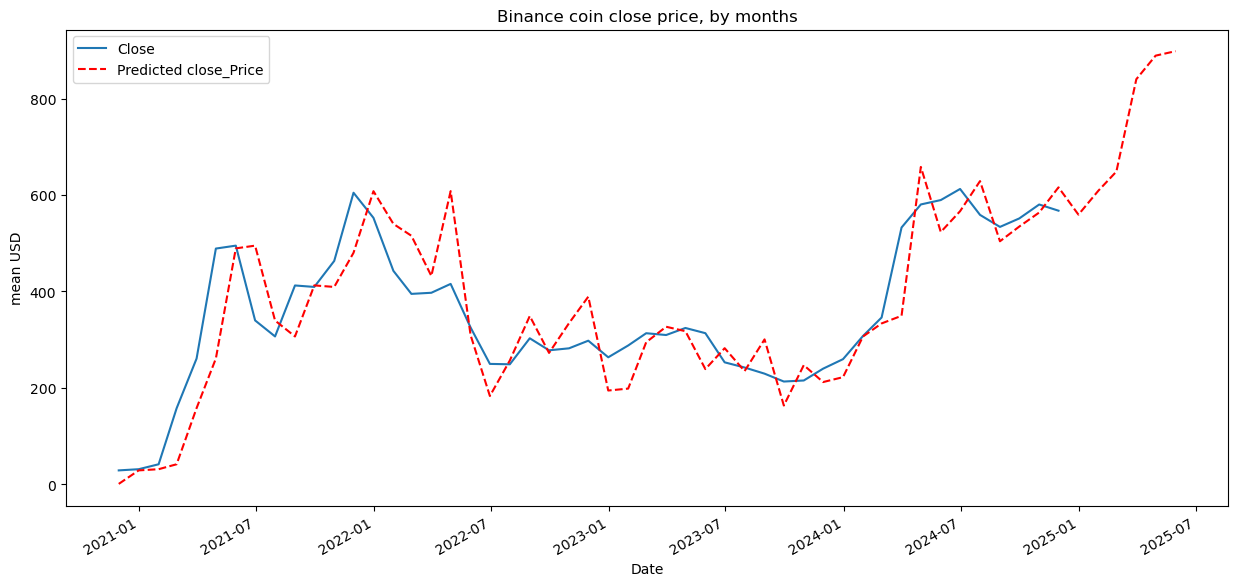

In [40]:
# Prediction
df_month2 = df_month[['Close']]
date_list = [datetime(2024, 11, 30), datetime(2024, 12, 31), datetime(2025, 1, 31), datetime(2025, 2, 28), 
             datetime(2025, 3, 31), datetime(2025, 4, 30), datetime(2025, 5, 31)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
df_month2.Close.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted close_Price')
plt.legend()
plt.title('Binance coin close price, by months')
plt.xlabel('Date')
plt.ylabel('mean USD')
plt.show()

In [15]:
# Create a DataFrame with the original 'Close' prices
df_month2 = df_month[['Close']].copy()

# Define future dates
date_list = [datetime(2024, 11, 30), datetime(2024, 12, 31), datetime(2025, 1, 31), 
             datetime(2025, 2, 28), datetime(2025, 3, 31), datetime(2025, 4, 30), 
             datetime(2025, 5, 31)]

# Create a DataFrame for the future predictions
future = pd.DataFrame(index=date_list, columns=df_month2.columns)

# Combine the original and future data
df_month2 = pd.concat([df_month2, future])

# Generate the predictions
df_month2['Predicted_Close_Price'] = invboxcox(best_model.predict(start=0, end=len(df_month2)-1), lmbda)

# Shift the predictions to align with the correct dates
df_month2['Predicted_Close_Price'] = df_month2['Predicted_Close_Price'].shift(-1)

# Reset the index and create a comparison table
comparison_table = df_month2.reset_index()
comparison_table.columns = ['Date', 'Original_Close_Price', 'Predicted_Close_Price']

# Display the fixed comparison table
print(comparison_table)


         Date  Original_Close_Price  Predicted_Close_Price
0  2020-11-30             29.012400              29.034817
1  2020-12-31             31.470000              31.473732
2  2021-01-31             41.706452              41.722208
3  2021-02-28            157.893929             158.076246
4  2021-03-31            260.867742             261.026760
5  2021-04-30            489.033667             489.387286
6  2021-05-31            495.094516             495.103249
7  2021-06-30            340.014667             339.779709
8  2021-07-31            306.793548             306.743215
9  2021-08-31            412.502581             412.665482
10 2021-09-30            409.450333             409.445416
11 2021-10-31            463.385806             480.252328
12 2021-11-30            604.792667             608.017109
13 2021-12-31            552.758387             540.189022
14 2022-01-31            442.777419             515.566717
15 2022-02-28            395.037500             432.2046

In [16]:
# Drop rows where Original_Close_Price or Predicted_Close_Price is NaN
valid_data = comparison_table.dropna(subset=['Original_Close_Price', 'Predicted_Close_Price'])

# Calculate absolute error
valid_data['Error'] = abs(valid_data['Original_Close_Price'] - valid_data['Predicted_Close_Price'])

# Mean Absolute Error (MAE)
mae = valid_data['Error'].mean()

# Mean Squared Error (MSE)
mse = ((valid_data['Original_Close_Price'] - valid_data['Predicted_Close_Price']) ** 2).mean()

# Mean Absolute Percentage Error (MAPE)
mape = (valid_data['Error'] / valid_data['Original_Close_Price']).mean() * 100

# Display the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")


Mean Absolute Error (MAE): 38.04905562170474
Mean Squared Error (MSE): 3493.0145343140057
Mean Absolute Percentage Error (MAPE): 11.228448905855133 %
